In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Binary Classification

Here, we use a tabular dataset from kaggle (https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset) with features on patients physical spine details possibly suited for classifying whether the person is 'abnormal' or 'normal' - possibly suffers back pain or not.   

We here just want to see how the training works with logistic regression (binary case). We set aside a proper handling of the learning experiment by splitting the data into a train and test partition (in general we would even have a validation partition). We focus here on making the system learn something. 

### Load Data

In [4]:
import pandas as pd
df = pd.read_csv("Dataset_spine.csv") # possibly modify!
df = df.drop(columns=['Unnamed: 13'])
N  = df.shape[0]
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


### Normalization and Turning into Torch Tensors

In [5]:
x0 = torch.from_numpy(df.values[:,0:-1].astype(np.float64))
X = (x0-torch.mean(x0, dim=0))/torch.std(x0,dim=0)
Y = torch.tensor(('Abnormal'==df.values[:,-1])).int().reshape(-1,1)
print(X.shape, Y.shape)

torch.Size([310, 12]) torch.Size([310, 1])


### (Binary) Logistic Regression

Data:  $\,\qquad X = \left(\begin{array}{cccc} 1 & X_{11} & \dots & X_{1n} \\ \vdots & \vdots & \vdots & \vdots \\ 1 & X_{N1} & \dots & X_{Nn}\end{array}\right)\qquad$ and $\qquad Y = \left(\begin{array}{c} Y_{1} \\ \vdots \\ Y_{N} \end{array}\right)$

Model: $\qquad\hat{Y}(X;W) = \sigma\left(X W^\intercal\right) \qquad$ where $\qquad W = \left(\begin{array}{c} W_0 \\ W_1 \\ \vdots \\ W_n \end{array}\right)$

The model outputs the probability of observing in a sample $x$ a '1' (Abnormal).

Cost:  $\,\qquad C(W) = -\frac{1}{N}\sum_j \left(Y_j\log(\hat{Y}_j(X;W)) + (1-Y_j)\log(1-\hat{Y}_j(X;W))\right)$

__Remark:__ Note that the logarithm diverges at arguments approaching 0. Make sure that you don't run into numerical issues.

Sigmoid = $f(x) = \frac{1}{1 + e^{-(b_0 + b_1x)}}$

In [6]:
# compose torch tensors X of shape (N,13) by inserting a column with 1's as first column  
X = torch.cat((torch.ones(N,1),X), dim=1)

In [509]:
# implement methods for predicting the probability of having label 0 or 1 (W with shape (1,13))
def predict(X,W):
    # YOUR CODE (START)
    return torch.div(1, torch.add(1, torch.exp(-(X@W.T))))
    # YOUR CODE (END)
    
def logits(X, W):
    return X@W.T

def cost(X,Y,W):
    # YOUR CODE (START)
    return torch.mean(torch.maximum(logits(X, W), torch.tensor(0)) - logits(X, W) * Y + torch.log(1 + torch.exp(-torch.abs(logits(X, W)))))
    # YOUR CODE (END)

In [492]:
def gradient_cost(X,Y,W):
    # YOUR CODE (START)
    Yhat = predict(X, W)
    return torch.div(X.T@torch.sub(Yhat, Y), len(X)).view(1,13)
    # YOUR CODE (END)
    
def accuracy(Y,Yhat):
    # YOUR CODE (START)
    Yhat_cat = torch.where(Yhat > 0.5, 1, 0)
    return torch.div((Y == Yhat_cat).sum(), len(Y))
    # YOUR CODE (END)

Just for testing:

In [506]:
W = torch.randn((1,13), dtype=torch.double)
print(predict(X[0],W))
print(cost(X,Y,W))
print(gradient_cost(X,Y,W))
print(accuracy(Y,predict(X,W)))

tensor([0.0227], dtype=torch.float64)
tensor(1.9567, dtype=torch.float64)
tensor([[-0.1433, -0.4143, -0.2989, -0.3307, -0.3091,  0.2909, -0.3395,  0.1063,
          0.1329,  0.0153, -0.0118,  0.1286, -0.0693]], dtype=torch.float64)
tensor(0.4194)


### Training

Training Accuracy (max,end): 0.861290, 0.861290
Training Cost (end): 0.323607


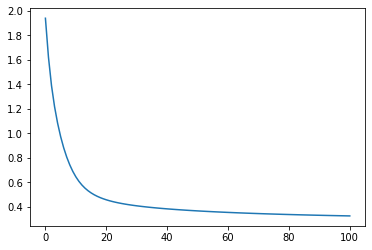

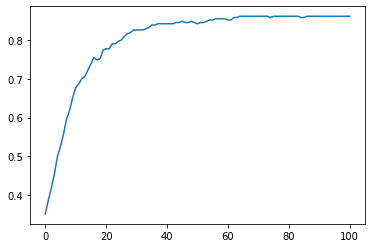

In [576]:
# adjust if needed
nepochs = 100
lr = 0.75

## initial parameter
W = torch.randn((1,13), dtype=torch.double)

# track the costs
costs = []
accs= []
costs = [cost(X,Y,W)]
accs = [accuracy(Y,predict(X,W))]

# YOUR CODE (START)

# loop over the epochs: update parameter values, compute the cost and add it to the costs list
for epoch in range(nepochs):
    dw = gradient_cost(X, Y, W)
    W = torch.sub(W, lr * dw)
    costs.append(cost(X,Y,W))
    accs.append(accuracy(Y,predict(X,W)))

# YOUR CODE (END)
    
# some output
accs = np.array(accs)

print("Training Accuracy (max,end): %f, %f"%(np.max(accs), accs[-1]))
print("Training Cost (end): %f"%costs[-1].item())
plt.figure(1)
plt.plot(range(nepochs+1),costs)
plt.figure(2)
plt.plot(range(nepochs+1),accs)

### Different Learning Rates

Play with different learning rates: Explore for what learning rates 
- the learning is most efficient
    - A learning rate of 0.75 seems to be very efficient
- the learning yet works
    - For example e learning rate of 5
- the learning does not work anymore (learning rate too large)
    - A learning rate bigger than 20 leads in this case usually to bad results. Especially, training costs are higher than with lower learning rates. Due to the high learning rate the minimal point can't be found.

Explain the different scenarios.

In [575]:
# adjust if needed
nepochs = 100

best_final_acc = {}

for lr in np.arange(0.05, 20, 0.05):
    ## initial parameter
    W = torch.randn((1,13), dtype=torch.double)

    # track the costs
    costs = []
    accs= []
    costs = [cost(X,Y,W)]
    accs = [accuracy(Y,predict(X,W))]

    # YOUR CODE (START)

    # loop over the epochs: update parameter values, compute the cost and add it to the costs list
    for epoch in range(nepochs):
        dw = gradient_cost(X, Y, W)
        W = torch.sub(W, lr * dw)
        costs.append(cost(X,Y,W))
        accs.append(accuracy(Y,predict(X,W)))

    # YOUR CODE (END)

    # some output
    accs = np.array(accs)
    
    best_final_acc[lr] = accs[-1]

In [574]:
# 8.05 is just sometimes a good learning rate. In some cases it wasn't able to come close enough to the minimum. 
# Therefore, a smaller learning rate should be used.
max(best_final_acc.items(), key = lambda k : k[1])

(8.05, 0.87419355)